In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

## Preprocessing data

#### Hourly data

In [2]:
load_path = 'processed_data/data_2006_2023.csv'

In [3]:
load_data = pd.read_csv(load_path)

In [4]:
## to make sure that data is stationary

# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [5]:
adf_test(load_data["loadConsumption"])

ADF Statistic: -27.204566436886566
p-value: 0.0
Data is stationary


In [6]:
load_data["datetime"] = pd.to_datetime(load_data["datetime"])

In [7]:
load_data

,loadConsumption,date,datetime,Hour,Year
0,10215.0000,2006-01-01,2005-12-31 23:00:00,0,2006
1,9979.0000,2006-01-01,2006-01-01 00:00:00,1,2006
2,9460.0000,2006-01-01,2006-01-01 01:00:00,2,2006
3,8833.0000,2006-01-01,2006-01-01 02:00:00,3,2006
4,8525.0000,2006-01-01,2006-01-01 03:00:00,4,2006
...,...,...,...,...,...
157767,12673.4650,2023-12-31,2023-12-31 19:00:00,20,2023
157768,12366.1950,2023-12-31,2023-12-31 20:00:00,21,2023
157769,12143.1775,2023-12-31,2023-12-31 21:00:00,22,2023
157770,11993.1200,2023-12-31,2023-12-31 22:00:00,23,2023


In [8]:
load_data.set_index("datetime", inplace=True)

In [9]:
avg_hourly_load = load_data.groupby(['Year', 'Hour'])['loadConsumption'].mean().reset_index()

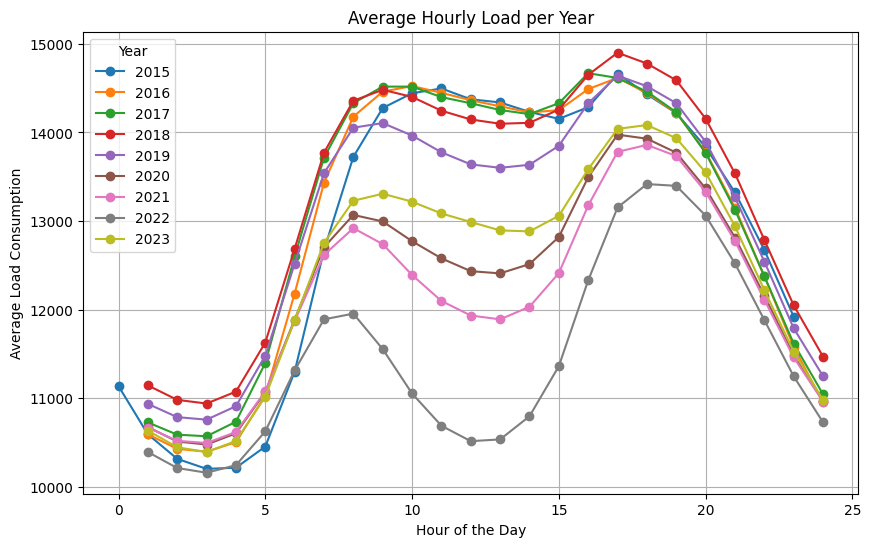

In [10]:
# Set the figure size for better readability
plt.figure(figsize=(10, 6))

# Loop through each unique year and plot its average load by hour
for year in avg_hourly_load['Year'].unique():
    if year >= 2015:  # Filter years from 2015 onwards
        subset = avg_hourly_load[avg_hourly_load['Year'] == year]
        plt.plot(subset['Hour'], subset['loadConsumption'], marker='o', label=str(year))
# Label the axes and add a title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Load Consumption')
plt.title('Average Hourly Load per Year')
plt.legend(title='Year')
plt.grid(True)

# Save the plot as a PNG image
plt.savefig('plots/average_hourly_load_per_year.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

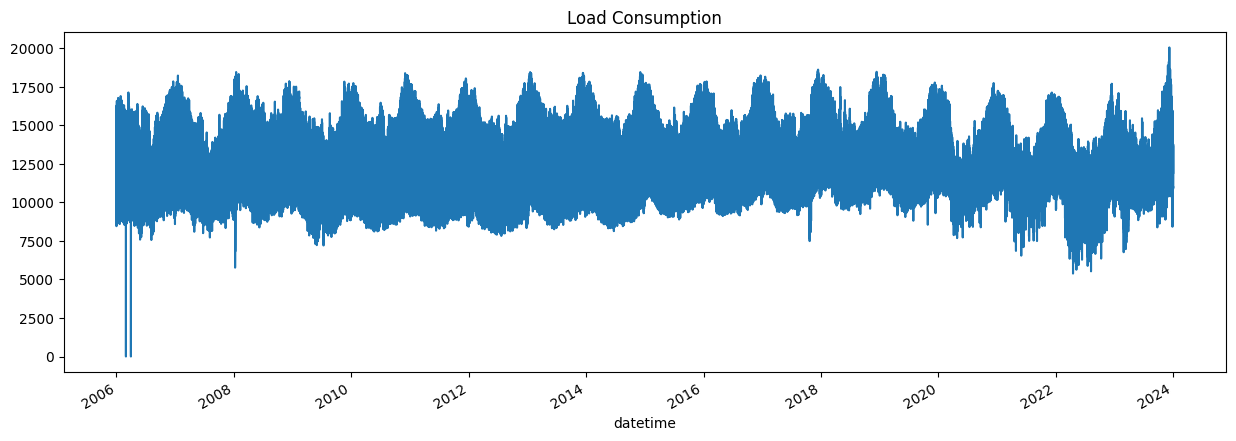

In [11]:
start_date = '2006-01-01'
end_date = '2023-12-31'

filtered_data = load_data.loc[start_date:end_date]
filtered_data['loadConsumption'].plot(
    style='-',
    figsize=(15, 5),
    color=color_pal[0],
    title='Load Consumption'
)

plt.savefig('Load_Consumption.png', dpi=300, bbox_inches='tight')

plt.show()

### Daily data

In [12]:
# Resample to daily data using sum
dailyLoad_data = filtered_data.groupby("date")["loadConsumption"].sum().reset_index()


In [13]:
#dailyLoad_data.set_index("date", inplace=True)

In [14]:
dailyLoad_data

,date,loadConsumption
0,2006-01-01,244807.0000
1,2006-01-02,314663.0000
2,2006-01-03,326082.0000
3,2006-01-04,328763.0000
4,2006-01-05,329469.0000
...,...,...
6569,2023-12-27,305610.2900
6570,2023-12-28,326312.3400
6571,2023-12-29,314575.3300
6572,2023-12-30,290563.1625


In [15]:
# Create lag features for the past 7 days
#for lag in range(1, 8):  # Lags for the past 7 days
#    dailyLoad_data[f'lag_{lag}'] = dailyLoad_data['loadConsumption'].shift(lag)

#Drop rows with NaN values created by shifting
#dailyLoad_data.dropna(inplace=True)

In [16]:
# Add rolling mean and standard deviation for the past 7 days
#dailyLoad_data['rolling_mean_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).mean()
#dailyLoad_data['rolling_std_7'] = dailyLoad_data['loadConsumption'].rolling(window=7).std()

# Drop rows with NaN values created by rolling
#dailyLoad_data.dropna(inplace=True)

In [17]:
# weather data
weather_data_path = 'processed_data/weather.csv' 
weather_data = pd.read_csv(weather_data_path)

In [18]:
#weather_data.head()

In [19]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

In [20]:
#weather_data.set_index("Date", inplace=True)

In [21]:
# Ensure 'Year' is an integer
weather_data["Year"] = weather_data["Year"].astype(int)

# Filter for Year >= 2015
weather_data = weather_data[weather_data["Year"] >= 2006]

In [22]:
weather_data

,Date,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
4018,2006-01-01,0.0,0.0,1,4.0,23,7,5.3,13,2.4,4.0,1,1.0,15,1,2006,52,200652,Sunday
4019,2006-01-02,-0.1,-0.1,10,1.5,-35,24,5.6,14,1.3,3.0,14,0.0,4,1,2006,1,200601,Monday
4020,2006-01-03,-0.1,-0.1,20,-0.2,-45,8,4.5,12,1.6,3.0,19,1.0,1,1,2006,1,200601,Tuesday
4021,2006-01-04,-0.1,-0.1,1,1.6,-5,24,3.8,13,2.9,5.0,21,1.0,3,1,2006,1,200601,Wednesday
4022,2006-01-05,0.0,0.0,1,0.7,-13,7,1.9,20,4.6,6.0,3,3.0,8,1,2006,1,200601,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10968,2025-01-11,-0.1,-0.1,1,0.5,-45,8,5.8,14,1.5,3.0,14,0.0,7,1,2025,2,202502,Saturday
10969,2025-01-12,0.1,0.1,21,1.7,-6,22,6.0,14,1.2,2.0,5,1.0,1,1,2025,2,202502,Sunday
10970,2025-01-13,0.0,0.0,1,0.5,-33,5,5.2,14,2.2,4.0,13,1.0,1,1,2025,3,202503,Monday
10971,2025-01-14,0.1,0.1,20,2.8,-16,1,5.7,24,3.1,5.0,13,2.0,6,1,2025,3,202503,Tuesday


In [23]:
dailyLoad_data.head()

,date,loadConsumption
0,2006-01-01,244807.0
1,2006-01-02,314663.0
2,2006-01-03,326082.0
3,2006-01-04,328763.0
4,2006-01-05,329469.0


In [24]:
# Ensure 'date' columns are in datetime format
dailyLoad_data["date"] = pd.to_datetime(dailyLoad_data["date"])
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

# Set index to 'date' for both DataFrames


# Merge without setting the index
merged_data = dailyLoad_data.merge(weather_data, left_on="date", right_on="Date", how="inner")

# Drop redundant date column if necessary
merged_data.drop(columns=["Date"], inplace=True)

In [25]:
merged_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2006-01-01,244807.0,0.0,0.0,1,4.0,23,7,5.3,13,2.4,4.0,1,1.0,15,1,2006,52,200652,Sunday
1,2006-01-02,314663.0,-0.1,-0.1,10,1.5,-35,24,5.6,14,1.3,3.0,14,0.0,4,1,2006,1,200601,Monday
2,2006-01-03,326082.0,-0.1,-0.1,20,-0.2,-45,8,4.5,12,1.6,3.0,19,1.0,1,1,2006,1,200601,Tuesday
3,2006-01-04,328763.0,-0.1,-0.1,1,1.6,-5,24,3.8,13,2.9,5.0,21,1.0,3,1,2006,1,200601,Wednesday
4,2006-01-05,329469.0,0.0,0.0,1,0.7,-13,7,1.9,20,4.6,6.0,3,3.0,8,1,2006,1,200601,Thursday


### Monthly Data

In [26]:
nao_path = 'processed_data/nao.csv'

In [27]:
nao = pd.read_csv(nao_path)

In [28]:
nao["Year"] = nao["Year"].astype(int)

# Filter for Year >= 2006
nao = nao[nao["Year"] >= 2006]

In [29]:
nao

,Year,Month,NAO
0,2006,1,1.27
1,2006,2,-0.51
2,2006,3,-1.28
3,2006,4,1.24
4,2006,5,-1.14
...,...,...,...
223,2024,8,0.63
224,2024,9,-1.43
225,2024,10,-0.38
226,2024,11,-0.23


In [30]:
nao["Year"] = nao["Year"].astype(int)
nao["Month"] = nao["Month"].astype(int)


### Half Year data

In [92]:
energyPrice_path = 'processed_data/energyPrice.csv'

In [93]:
energyPrice = pd.read_csv(energyPrice_path)

In [94]:
energyPrice["Year"] = energyPrice["Year"].astype(int)

# Filter for Year >= 2015
energyPrice = energyPrice[energyPrice["Year"] >= 2006]

In [95]:
energyPrice.head()

,Year,PriceComponents,Periods,NG_Household_LessThan_569m3_EuroPerM3,NG_Household_569to5687m3_EuroPerM3,NG_Household_MoreThan_5687m3_EuroPerM3,NG_NonHousehold_LessThan_28433m3_EuroPerM3,NG_NonHousehold_28433to284333m3_EuroPerM3,NG_NonHousehold_284333to2843332m3_EuroPerM3,NG_NonHousehold_2843332to28433324m3_EuroPerM3,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
0,2009,TotalPrice,2009 1e halfjaar,1.057,0.791,0.722,0.752,0.662,0.459,0.374,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
1,2009,TotalPrice,2009 2e halfjaar,1.031,0.658,0.572,0.622,0.612,0.407,0.330,...,0.147,0.127,0.116,0.099,0.094,0.072,0.1246,0.123714,0.753667,0.4422
2,2009,TotalPrice,2009,1.045,0.735,0.656,0.706,0.644,0.435,0.352,...,0.167,0.129,0.117,0.104,0.098,0.076,0.1340,0.128857,0.812000,0.4784
3,2010,TotalPrice,2010 1e halfjaar,0.943,0.664,0.593,0.621,0.545,0.390,0.296,...,0.175,0.120,0.106,0.091,0.087,0.074,0.1176,0.123429,0.733333,0.4156
4,2010,TotalPrice,2010 2e halfjaar,1.060,0.703,0.608,0.621,0.590,0.360,0.302,...,0.134,0.115,0.106,0.085,0.086,0.076,0.1118,0.114286,0.790333,0.4258


In [96]:
# Keep only rows where PriceComponents is "TotalPrice"
energyPrice = energyPrice[energyPrice["PriceComponents"] == "TotalPrice"]

In [97]:
# Keep only rows that have "halfjaar" in the Periods column
energyPrice = energyPrice[energyPrice["Periods"].str.contains("halfjaar", na=False)]

In [98]:
import re

def clean_year(period):
    return re.sub(r"\D", "", period.split()[0])  # Remove non-numeric characters

# Apply cleaning to the Year part of "Periods"
energyPrice["Year"] = energyPrice["Periods"].apply(clean_year).astype(int)

# Now apply the original function safely
def convert_to_date(period):
    year = int(re.sub(r"\D", "", period.split()[0]))  # Remove any unwanted characters
    if "1e halfjaar" in period:  # First half-year
        return f"{year}-01-01"
    elif "2e halfjaar" in period:  # Second half-year
        return f"{year}-07-01"
    else:  # Full year entry
        return f"{year}-01-01"

# Apply function
energyPrice["Start_Date"] = energyPrice["Periods"].apply(convert_to_date)
energyPrice["Start_Date"] = pd.to_datetime(energyPrice["Start_Date"]) 

In [99]:
# Create an empty list to store expanded rows
expanded_rows = []

# Iterate through each row and expand to daily records
for _, row in energyPrice.iterrows():
    start_date = row["Start_Date"]
    end_date = start_date + pd.DateOffset(months=6) - pd.Timedelta(days=1)  # Define half-year range
    daily_range = pd.date_range(start=start_date, end=end_date, freq='D')  # Generate daily dates
    
    # Create a DataFrame with repeated daily values
    temp_df = pd.DataFrame({"date": daily_range})
    
    # Assign the corresponding price columns to each daily row
    for col in energyPrice.columns[3:-1]:  # Exclude "Year", "PriceComponents", "Periods", and "Start_Date"
        temp_df[col] = row[col]  
    
    expanded_rows.append(temp_df)  # Append expanded rows

# Concatenate all daily records into a single DataFrame
daily_energy_price = pd.concat(expanded_rows, ignore_index=True)

In [100]:
daily_energy_price

,date,NG_Household_LessThan_569m3_EuroPerM3,NG_Household_569to5687m3_EuroPerM3,NG_Household_MoreThan_5687m3_EuroPerM3,NG_NonHousehold_LessThan_28433m3_EuroPerM3,NG_NonHousehold_28433to284333m3_EuroPerM3,NG_NonHousehold_284333to2843332m3_EuroPerM3,NG_NonHousehold_2843332to28433324m3_EuroPerM3,NG_NonHousehold_MoreThan_28433324m3_EuroPerM3,Electricity_Household_LessThan_1MWh_EuroPerKWh,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
0,2009-01-01,1.057,0.791,0.722,0.752,0.662,0.459,0.374,0.276,-0.103,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
1,2009-01-02,1.057,0.791,0.722,0.752,0.662,0.459,0.374,0.276,-0.103,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
2,2009-01-03,1.057,0.791,0.722,0.752,0.662,0.459,0.374,0.276,-0.103,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
3,2009-01-04,1.057,0.791,0.722,0.752,0.662,0.459,0.374,0.276,-0.103,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
4,2009-01-05,1.057,0.791,0.722,0.752,0.662,0.459,0.374,0.276,-0.103,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655,2024-06-26,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.240,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5656,2024-06-27,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.240,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5657,2024-06-28,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.240,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402
5658,2024-06-29,1.924,1.588,1.417,1.594,1.467,0.849,0.736,0.555,-0.041,...,0.324,0.240,0.232,0.201,0.240,0.174,0.2188,0.255286,1.643000,1.0402


### Yearly Data

In [101]:
gdp_path = 'processed_data/GDP.csv'
gdp = pd.read_csv(gdp_path)

# Ensure 'Year' is numeric and filter
gdp["Year"] = gdp["Year"].astype(int)
gdp = gdp[gdp["Year"] >= 2006]

In [102]:
gdp.head()

,Year,GDP
11,2006,642232
12,2007,666462
13,2008,680926
14,2009,655958
15,2010,664765


In [103]:
elecBalance_path = 'processed_data/elecBalance.csv'

In [104]:
elecBalance = pd.read_csv(elecBalance_path)

In [105]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing 'PJ' to convert
columns_to_convert = [col for col in elecBalance.columns if '(PJ)' in col]

# Apply conversion and rename columns
for col in columns_to_convert:
    elecBalance[col.replace("(PJ)", "(MWh)")] = elecBalance[col] * conversion_factor

# Drop original columns
elecBalance.drop(columns=columns_to_convert, inplace=True)

In [106]:
### consumption of electricity by orginal source?

In [107]:
elecBalance.head()

,Year,Commercial and public services (MWh),"Electricity, CHP and heat plants (MWh)",Exports (MWh),Imports (MWh),Industry (MWh),"Oil refineries, transformation (MWh)",Other final consumption (MWh),Production (MWh),Residential (MWh),Total energy supply (MWh),Total final consumption (MWh),Transport (MWh)
0,2006,3.462703e+07,9.883308e+07,-5.887005e+06,2.734602e+07,4.150914e+07,0,5.745005e+06,0,2.208102e+07,2.145902e+07,1.055762e+08,1.614001e+06
1,2007,3.541703e+07,1.051661e+08,-5.480005e+06,2.308902e+07,4.217803e+07,0,6.298005e+06,0,2.226802e+07,1.760901e+07,1.077511e+08,1.590001e+06
2,2008,3.588903e+07,1.075521e+08,-9.116007e+06,2.496702e+07,4.188160e+07,0,6.528006e+06,0,2.250102e+07,1.585101e+07,1.084237e+08,1.624002e+06
3,2009,3.654703e+07,1.136901e+08,-1.056101e+07,1.545201e+07,3.647583e+07,0,7.083006e+06,0,2.287202e+07,4.891004e+06,1.046559e+08,1.678001e+06
4,2010,3.676603e+07,1.192691e+08,-1.280801e+07,1.558301e+07,3.910208e+07,0,7.024006e+06,0,2.299402e+07,2.775003e+06,1.076421e+08,1.756001e+06


In [108]:
elecBalance["Year"] = elecBalance["Year"].astype(int)

# Filter for Year >= 2015
elecBalance = elecBalance[elecBalance["Year"] >= 2006]

In [112]:
population_path = 'processed_data/populationNL.csv'

In [113]:
populationNL = pd.read_csv(population_path)

In [114]:
populationNL["Year"] = populationNL["Year"].astype(int)

# Filter for Year >= 2015
populationNL = populationNL[populationNL["Year"] >= 26]

In [115]:
populationNL

,Year,Population
0,2006,16.33
1,2007,16.36
2,2008,16.41
3,2009,16.49
4,2010,16.57
5,2011,16.66
6,2012,16.73
7,2013,16.78
8,2014,16.83
9,2015,16.90


In [116]:
res_path = 'processed_data/renwableEnergy.csv'

In [117]:
rEnergy = pd.read_csv(res_path)

In [118]:
# Convert all columns from TJ to MWh (1 TJ = 277.78 MWh)
conversion_factor = 277.78

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in rEnergy.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    rEnergy[col + " (MWh)"] = rEnergy[col] * conversion_factor

# Drop original columns
rEnergy.drop(columns=columns_to_convert, inplace=True)


In [119]:
rEnergy["Year"] = rEnergy["Year"].astype(int)

# Filter for Year >= 2006
rEnergy = rEnergy[rEnergy["Year"] >= 2006]

In [120]:
### production of renewable energy per source?

In [121]:
rEnergy

,Year,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh)
0,2006,233335.20,25000.20,233335.20,14487893.68,17632918.84,17632918.84,2540298.10,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.90
1,2007,316946.98,29444.68,316946.98,16719022.64,20589886.94,20589886.94,3165580.88,259446.52,6.244097e+08,99445.24,2862245.12,303335.76,37500.30,221668.44
2,2008,413336.64,54167.10,440003.52,18006532.94,22800460.18,22800460.18,3925309.18,274446.64,6.340309e+08,100000.80,3376138.12,549171.06,39722.54,235001.88
3,2009,511392.98,97500.78,550837.74,20485441.66,26016874.80,26016874.80,4480869.18,302224.64,6.098754e+08,100000.80,3761974.54,718894.64,45000.36,257224.28
4,2010,606393.74,148890.08,694727.78,19890436.90,25669927.58,25669927.58,4502813.80,332224.88,6.553997e+08,101111.92,3737529.90,765283.90,55833.78,276113.32
5,2011,705005.64,204723.86,792784.12,21356004.18,27571331.68,27571331.68,4725037.80,393336.48,6.091479e+08,99445.24,3982254.08,742783.72,104445.28,288891.20
6,2012,792228.56,266946.58,929729.66,21797396.60,28521339.28,28521339.28,4938928.40,488059.46,6.120263e+08,100278.58,4156422.14,782506.26,190557.08,297224.60
7,2013,874173.66,341669.40,1150009.20,21062668.50,28739952.14,28739952.14,5367820.72,717227.96,6.125599e+08,100556.36,4632259.28,735561.44,410003.28,307224.68
8,2014,945563.12,442225.76,1362788.68,21477116.26,30232186.30,30232186.30,5809490.92,1038619.42,5.580928e+08,101945.26,5059762.70,750006.00,725283.58,313335.84
9,2015,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.00,1424178.06,5.684820e+08,98611.90,5881713.72,1035286.06,1108619.98,315835.86


In [122]:
YearlyFinalCons_path = 'processed_data/yearlyfinalConsPerSource.csv'

In [123]:
YearlyFinalCons = pd.read_csv(YearlyFinalCons_path)

In [124]:
# Convert all columns from PJ to MWh (1 PJ = 277,778 MWh)
conversion_factor = 277778

# Identify columns containing energy values (assuming all except "Year")
columns_to_convert = [col for col in YearlyFinalCons.columns if col != "Year"]

# Apply conversion and rename columns
for col in columns_to_convert:
    YearlyFinalCons[col + " (MWh)"] = YearlyFinalCons[col] * conversion_factor

# Drop the original PJ columns
YearlyFinalCons.drop(columns=columns_to_convert, inplace=True)

In [125]:
 YearlyFinalCons["Year"] = YearlyFinalCons["Year"].astype(int)

# Filter for Year >= 2006
YearlyFinalCons = YearlyFinalCons[YearlyFinalCons["Year"] >= 2006]


In [126]:
### Final consumption of each source

In [127]:
YearlyFinalCons

,Year,"Crude, NGL and feedstocks (MWh)",Electricity (MWh),Heat (MWh),Natural gas (MWh),Oil products (MWh),Renewables and waste (MWh),Total (MWh)
0,2006,4.244781e+07,1.055762e+08,3.734086e+07,2.494907e+08,2.800033e+08,8.638014e+06,7.300524e+08
1,2007,3.494892e+07,1.077511e+08,3.724892e+07,2.351998e+08,2.817874e+08,1.222542e+07,7.162591e+08
2,2008,3.405114e+07,1.084237e+08,3.696336e+07,2.460331e+08,2.682002e+08,1.221741e+07,7.116699e+08
3,2009,3.293225e+07,1.046559e+08,3.325308e+07,2.464315e+08,2.645401e+08,1.334307e+07,7.012903e+08
4,2010,3.249114e+07,1.076421e+08,3.489086e+07,2.868814e+08,2.802510e+08,1.177097e+07,7.591134e+08
5,2011,3.352336e+07,1.077658e+08,3.314364e+07,2.450446e+08,2.646960e+08,1.269741e+07,7.027998e+08
6,2012,2.996780e+07,1.042157e+08,3.126641e+07,2.561520e+08,2.691821e+08,1.289261e+07,7.105101e+08
7,2013,3.101336e+07,1.045519e+08,3.132336e+07,2.565018e+08,2.544146e+08,1.303391e+07,6.967053e+08
8,2014,3.158002e+07,1.015782e+08,3.030419e+07,2.179689e+08,2.402847e+08,1.437882e+07,6.415663e+08
9,2015,2.561924e+07,1.036768e+08,2.634479e+07,2.247547e+08,2.478791e+08,1.408313e+07,6.483023e+08


In [128]:
merged_Yearly_data = pd.merge(populationNL, rEnergy, on=["Year"], how="inner")

In [129]:
merged_Yearly_data = pd.merge(merged_Yearly_data, gdp, on=["Year"], how="inner")

In [130]:
merged_Yearly_data.head()

,Year,Population,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh),GDP
0,2006,16.33,233335.20,25000.20,233335.20,14487893.68,17632918.84,17632918.84,2540298.10,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.90,642232
1,2006,16.33,233335.20,25000.20,233335.20,14487893.68,17632918.84,17632918.84,2540298.10,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.90,584546
2,2007,16.36,316946.98,29444.68,316946.98,16719022.64,20589886.94,20589886.94,3165580.88,259446.52,6.244097e+08,99445.24,2862245.12,303335.76,37500.30,221668.44,666462
3,2007,16.36,316946.98,29444.68,316946.98,16719022.64,20589886.94,20589886.94,3165580.88,259446.52,6.244097e+08,99445.24,2862245.12,303335.76,37500.30,221668.44,619170
4,2008,16.41,413336.64,54167.10,440003.52,18006532.94,22800460.18,22800460.18,3925309.18,274446.64,6.340309e+08,100000.80,3376138.12,549171.06,39722.54,235001.88,680926


In [131]:
merged_Yearly_data.columns

Index(['Year', 'Population', 'GeothermalHeat (MWh)', 'AmbientAirHeat (MWh)',
       'TotalGeothermal&GroundEnergy (MWh)', 'TotalBiomass (MWh)',
       'TotalRes(excl.Stat.Transfer) (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'Hydropower (MWh)', 'OnshoreWindEnergy (MWh)',
       'OffshoreWindEnergy (MWh)', 'SolarPower (MWh)',
       'SolarThermalEnergy (MWh)', 'GDP'],
      dtype='object')

## Merging All Data on Daily basis

In [132]:
# Convert date column to datetime format in daily data
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Extract year and month for merging
merged_data['Year'] = merged_data['date'].dt.year
merged_data['Month'] = merged_data['date'].dt.month

In [133]:
# Merge daily with monthly data on Year and Month
nao_loadCons = merged_data.merge(nao, on=['Year', 'Month'], how='inner', suffixes=('', '_monthly'))

In [134]:
# Merge the result with yearly data on Year
yearly_daily_data = nao_loadCons.merge(merged_Yearly_data, on=['Year'], how='inner', suffixes=('', '_yearly'))

In [135]:
yearly_daily_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),Hydropower (MWh),OnshoreWindEnergy (MWh),OffshoreWindEnergy (MWh),SolarPower (MWh),SolarThermalEnergy (MWh),GDP
0,2006-01-01,244807.0,0.0,0.0,1,4.0,23,7,5.3,13,...,17632918.84,2540298.1,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.9,642232
1,2006-01-01,244807.0,0.0,0.0,1,4.0,23,7,5.3,13,...,17632918.84,2540298.1,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.9,584546
2,2006-01-02,314663.0,-0.1,-0.1,10,1.5,-35,24,5.6,14,...,17632918.84,2540298.1,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.9,642232
3,2006-01-02,314663.0,-0.1,-0.1,10,1.5,-35,24,5.6,14,...,17632918.84,2540298.1,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.9,584546
4,2006-01-03,326082.0,-0.1,-0.1,20,-0.2,-45,8,4.5,12,...,17632918.84,2540298.1,246113.08,6.346665e+08,100278.58,2476964.26,63333.84,36666.96,209723.9,642232


In [136]:
all_data = pd.merge(yearly_daily_data, daily_energy_price, on=["date"], how="inner")

In [137]:
all_data

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,...,Electricity_NonHousehold_20to500MWh_EuroPerKWh,Electricity_NonHousehold_500to2000MWh_EuroPerKWh,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold
0,2009-01-01,280721.0000,0.0,0.0,1,-0.6,-28,1,0.5,24,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
1,2009-01-01,280721.0000,0.0,0.0,1,-0.6,-28,1,0.5,24,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
2,2009-01-02,297433.0000,0.5,0.5,5,-0.8,-72,24,1.9,10,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
3,2009-01-02,297433.0000,0.5,0.5,5,-0.8,-72,24,1.9,10,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
4,2009-01-03,307080.0000,-0.1,-0.1,22,-2.7,-89,6,1.6,24,...,0.187,0.132,0.118,0.108,0.104,0.080,0.1424,0.134429,0.856667,0.5046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10951,2023-12-29,314575.3300,3.8,1.4,16,9.3,55,18,11.4,13,...,0.287,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218
10952,2023-12-30,290563.1625,-0.1,-0.1,1,8.1,55,7,9.7,18,...,0.287,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218
10953,2023-12-30,290563.1625,-0.1,-0.1,1,8.1,55,7,9.7,18,...,0.287,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218
10954,2023-12-31,296833.7350,2.8,1.6,10,8.8,79,22,9.5,17,...,0.287,0.251,0.278,0.217,0.291,0.237,0.2128,0.277143,1.671333,1.0218


In [138]:
all_data.columns

Index(['date', 'loadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'WeekKey', 'day_of_week', 'NAO', 'Population',
       'GeothermalHeat (MWh)', 'AmbientAirHeat (MWh)',
       'TotalGeothermal&GroundEnergy (MWh)', 'TotalBiomass (MWh)',
       'TotalRes(excl.Stat.Transfer) (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'Hydropower (MWh)', 'OnshoreWindEnergy (MWh)',
       'OffshoreWindEnergy (MWh)', 'SolarPower (MWh)',
       'SolarThermalEnergy (MWh)', 'GDP',
       'NG_Household_LessThan_569m3_EuroPerM3',
       'NG_Household_569to5687m3_EuroPerM3',
   

In [139]:
coloumn_to_keep = ['date', 'loadConsumption', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'day_of_week', 'NAO', 'Population',
       'TotalBiomass (MWh)',
       'TotalRes(incl.Stat.Transfer) (MWh)', 'Totaal windenergie (MWh)',
       'TotalSolarEnergy (MWh)', 'Total Including Non-Renewable (MWh)',
       'AveragePrice_Electricity_Household',
       'AveragePrice_Electricity_NonHousehold',
       'AveragePrice_NaturalGas_Household',
       'AveragePrice_NaturalGas_NonHousehold', 'GDP']

In [140]:
# Identify non-numeric columns
non_numeric_cols = all_data.select_dtypes(include=['object']).columns
print("Categorical Columns:", non_numeric_cols)


Categorical Columns: Index(['day_of_week'], dtype='object')


In [141]:
all_data = all_data[coloumn_to_keep]

In [142]:
from sklearn.preprocessing import LabelEncoder

# Label encode 'day_of_week'
label_encoder = LabelEncoder()
all_data["day_of_week"] = label_encoder.fit_transform(all_data["day_of_week"])

C:\Users\mahmo\AppData\Local\Temp\ipykernel_2796\1803951313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data["day_of_week"] = label_encoder.fit_transform(all_data["day_of_week"])


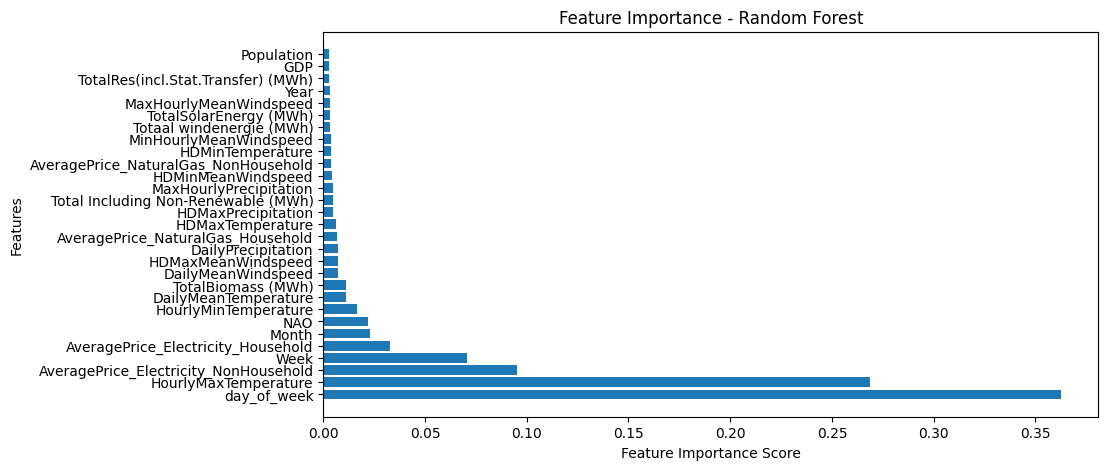

In [143]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target
X = all_data.drop(columns=["loadConsumption", 'date'])  # Excluding target variable
y = all_data["loadConsumption"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Visualize importance
import matplotlib.pyplot as plt
import pandas as pd

feat_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df["Feature"], feat_importance_df["Importance"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.show()

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define the feature set (excluding target variable)
X = all_data.drop(columns=["loadConsumption", 'date']) 

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display results
print(vif_data.sort_values(by="VIF", ascending=False))


                                  Feature            VIF
14                                   Year  317305.570221
22                 TotalSolarEnergy (MWh)     319.170001
25  AveragePrice_Electricity_NonHousehold     285.332149
27   AveragePrice_NaturalGas_NonHousehold     203.682531
20     TotalRes(incl.Stat.Transfer) (MWh)     189.899495
18                             Population     148.280423
3                    DailyMeanTemperature     103.207940
21               Totaal windenergie (MWh)     102.383156
26      AveragePrice_NaturalGas_Household      63.260186
19                     TotalBiomass (MWh)      49.278988
6                    HourlyMaxTemperature      48.694205
24     AveragePrice_Electricity_Household      21.287838
4                    HourlyMinTemperature      20.587798
13                                  Month      18.405717
8                      DailyMeanWindspeed      17.896022
15                                   Week      17.718855
9                  MaxHourlyMea

In [145]:
# Drop low-importance features
low_importance_features = [
    "HDMinMeanWindspeed", "HDMaxMeanWindspeed", "HDMaxPrecipitation",
    "HDMinTemperature", "HDMaxTemperature", "NAO"
]

all_data = all_data.drop(columns=low_importance_features)


In [146]:
# Save the merged dataset
merged_file_path = "merged_data_granualityBased/_data_(daily).csv"
all_data.to_csv(merged_file_path, index=False)

In [147]:
all_data.isna().sum()

date                                     0
loadConsumption                          0
DailyPrecipitation                       0
MaxHourlyPrecipitation                   0
DailyMeanTemperature                     0
HourlyMinTemperature                     0
HourlyMaxTemperature                     0
DailyMeanWindspeed                       0
MaxHourlyMeanWindspeed                   0
MinHourlyMeanWindspeed                   0
Month                                    0
Year                                     0
Week                                     0
day_of_week                              0
Population                               0
TotalBiomass (MWh)                       0
TotalRes(incl.Stat.Transfer) (MWh)       0
Totaal windenergie (MWh)                 0
TotalSolarEnergy (MWh)                   0
Total Including Non-Renewable (MWh)      0
AveragePrice_Electricity_Household       0
AveragePrice_Electricity_NonHousehold    0
AveragePrice_NaturalGas_Household        0
AveragePric